# Lab 2: Modeling Stellar Spectra (due 4pm 4/6)
## Jacqueline Telson

### Problem 1

To download the files in each field (M15, N6791, K2_C4_168-21, 060+00), I entered these commands into my computer terminal, in the working directory:

rsync -aLvz --prune-empty-dirs --progress rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-*.fits .

rsync -aLvz --prune-empty-dirs --progress rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-*.fits .

rsync -aLvz --prune-empty-dirs --progress rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-*.fits .

rsync -aLvz --prune-empty-dirs --progress rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-*.fits .

Number of files

    M15: 1334
    N6791: 265
    K2_C4_168-21: 439
    060+00: 998
    total: 3036

The coadded multi-visit spectra is the sum of all the individual visit spectra. There are multiple visits on one star because "multiple observations are made at different epochs to allow for the identification of binary stars through detection of their radial velocity variations" (SDSS website). 

The coadded spectra have already been Doppler shifted to the barycentric frame, this means that the wavelength axis has been rescaled to take into account redshift. In effect, every wavelength value gets its resepctive $\delta \lambda / \lambda$ value added to it. The doppler shift will be different for each visit becuase the stars are moving. They are moving away from us due to the universe expanding, they have a motion around the galactic center, and they are moving slightly around their system's center of motion (if they have planets, etc).

In [1]:
import numpy as np
import astropy.io.fits as pf
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [3]:
# read in each spectrum (inclusing fluxes, errors, and bitmasks)
ids = []
fluxes = []
errors = []
bitmasks = []
    
for field in ['M15', 'N6791', 'K2_C4_168-21', '060+00']:
    for filename in listdir_nohidden(field):
        file = pf.open(field+'/'+filename)
        header = file[0].header
        object_id = header['OBJID']
        combined_spectra = file[1].data[0]
        error = file[2].data[0]
        bitmask = file[3].data[0]
    
        ids += [object_id]
        fluxes += [combined_spectra]
        errors += [error]
        bitmasks += [bitmask]

In [4]:
# reconstruct wavelength array (lambdas)
f = pf.open('M15/apStar-r12-2M21233217+1211528.fits')
crval1 = f[1].header['CRVAL1']
cdelt1 = f[1].header['CDELT1']
lambdas = 10**(np.linspace(crval1, cdelt1*8575+crval1, num=8575))

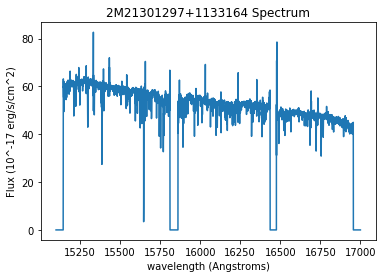

In [5]:
# plot an example spectrum (I just used the first star in the set)
plt.plot(lambdas, fluxes[0])
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('Flux (10^-17 erg/s/cm^2)')
plt.title(ids[0]+' Spectrum')
plt.show()

The x-axis units are in Angstroms (they were originally in the file as log(Angstroms), but I transformed them to be on a linear scale). The y-axis units are 10^-17 erg/s/cm^2.

### Problem 2

In [6]:
# download stellar property labels from allStar catalog (I used the "Lite" version to save space on my laptop)
from astropy.table import Table

allStar_table = Table.read('allStarLite-r12-l33.fits', hdu=1)

In [7]:
# narrow down table of label values to only include the stars from the previous problem
fields = ['M15', 'N6791', 'K2_C4_168-21', '060+00']
not_in_fields = [(row not in fields) for row in allStar_table['FIELD']]
allStar_table.remove_rows(not_in_fields)
allStar_table

APOGEE_ID,TELESCOPE,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE_TARGET3,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,TARGFLAGS,SURVEY,PROGRAMNAME,NINST [3],NVISITS,COMBTYPE,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,OBSVHELIO_AVG,OBSVSCATTER,OBSVERR,OBSVERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],MEANFIB,SIGFIB,SNREV,APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,MIN_H,MAX_H,MIN_JK,MAX_JK,TEFF,TEFF_ERR,LOGG,LOGG_ERR,VMICRO,VMACRO,VSINI,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [9],X_H [26],X_H_ERR [26],X_M [26],X_M_ERR [26],C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE,CU_FE,GE_FE,RB_FE,CE_FE,ND_FE,YB_FE,C_FE_ERR,CI_FE_ERR,N_FE_ERR,O_FE_ERR,NA_FE_ERR,MG_FE_ERR,AL_FE_ERR,SI_FE_ERR,P_FE_ERR,S_FE_ERR,K_FE_ERR,CA_FE_ERR,TI_FE_ERR,TIII_FE_ERR,V_FE_ERR,CR_FE_ERR,MN_FE_ERR,FE_H_ERR,CO_FE_ERR,NI_FE_ERR,CU_FE_ERR,GE_FE_ERR,RB_FE_ERR,CE_FE_ERR,ND_FE_ERR,YB_FE_ERR,C_FE_FLAG,CI_FE_FLAG,N_FE_FLAG,O_FE_FLAG,NA_FE_FLAG,MG_FE_FLAG,AL_FE_FLAG,SI_FE_FLAG,P_FE_FLAG,S_FE_FLAG,K_FE_FLAG,CA_FE_FLAG,TI_FE_FLAG,TIII_FE_FLAG,V_FE_FLAG,CR_FE_FLAG,MN_FE_FLAG,FE_H_FLAG,CO_FE_FLAG,NI_FE_FLAG,CU_FE_FLAG,GE_FE_FLAG,RB_FE_FLAG,CE_FE_FLAG,ND_FE_FLAG,YB_FE_FLAG,ELEM_CHI2 [26],ALT_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,GAIA_SOURCE_ID,GAIA_PARALLAX,GAIA_PARALLAX_ERROR,GAIA_PMRA,GAIA_PMRA_ERROR,GAIA_PMDEC,GAIA_PMDEC_ERROR,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,GAIA_RADIAL_VELOCITY,GAIA_RADIAL_VELOCITY_ERROR,GAIA_R_EST,GAIA_R_LO,GAIA_R_HI,TEFF_SPEC,LOGG_SPEC
bytes18,bytes8,bytes16,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,bytes192,bytes35,bytes18,int32,int32,int32,int16,float32,int32,bytes160,int32,bytes58,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes5,bytes3,bytes7,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes5,int32,bytes104,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,bytes47,bytes14,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,int16,int16,int64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32
2M03501997+2458304,apo25m,K2_C4_168-21,11.651,0.022,10.948,0.021,10.817,0.018,57.583225,24.975134,166.548515381,-22.3761108397,0,0,0,-2147465198,0,0,"APOGEE2_TWOBIN_0_5_TO_0_8,APOGEE2_WISE_DERED,APOGEE2_SHORT,APOGEE2_NORMAL_SAMPLE",apogee2-manga,k2,0 .. 2,2,1,0,137.744,0,,0,,-5.52631,0.0604696,0.0197684,0.0291861,-5.50471,0.067113,0.016

In [8]:
# Discard all spectra for which Teff, logg, [Fe/H], [Mg/Fe], and [Si/Fe] have not been derived
allStar_table.remove_rows([(row == -9999.99) for row in allStar_table['TEFF']])
allStar_table.remove_rows([(row == -9999.99) for row in allStar_table['LOGG']])
allStar_table.remove_rows([(row == -9999.99) for row in allStar_table['FE_H']])
allStar_table.remove_rows([(row == -9999.99) for row in allStar_table['MG_FE']])
allStar_table.remove_rows([(row == -9999.99) for row in allStar_table['SI_FE']])
allStar_table.remove_rows([(row < 50) for row in allStar_table['SNR']])
allStar_table.remove_rows([(row > 4) for row in allStar_table['LOGG']])
allStar_table.remove_rows([(row > 5700) for row in allStar_table['TEFF']])
allStar_table.remove_rows([(row < -1) for row in allStar_table['FE_H']])

In [9]:
# should be left with 1855 stars
len(allStar_table)

1854

Our cut on logg effectively distinguishes between dwarfs and giants becuase the logg values of dwarfs are of order 10. Therefore, by cutting out all logg values greater than 4, we have cut out all the small dwarf stars.  

In [234]:
# For a solar mass star, calculate the expected value of log g on the main sequence (when R ∼ 1R⊙), 
# just before the helium flash (when R ∼ 100R⊙), and during core helium burning (when R ∼ 15R⊙).

#g = G*M/(r**2)
G = 6.67 * 10**-11 # m^3 kg^-1 s^-2
M = 2 * 10**30 # kg
R = 6.96 * 10**8 # m (solar radius)

print('Main Sequence: logg = ', np.log10(G*M/(R)))
print('Just before Helium Flash: logg = ', np.log10(G*M/(100*R)))
print('During Core Helium Burning: logg = ', np.log10(G*M/(15*R)))

Main Sequence: logg =  11.282546589969968
Just before Helium Flash: logg =  9.282546589969968
During Core Helium Burning: logg =  10.106455330914287


In [33]:
# restructure data so that it can be inputted into corner function
data = np.hstack(allStar_table['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE'])
new_data = []
for row in data:
    new_row = []
    for i in row:
        new_row.append(i)
    new_data.append(new_row)

new_data = np.array(new_data)

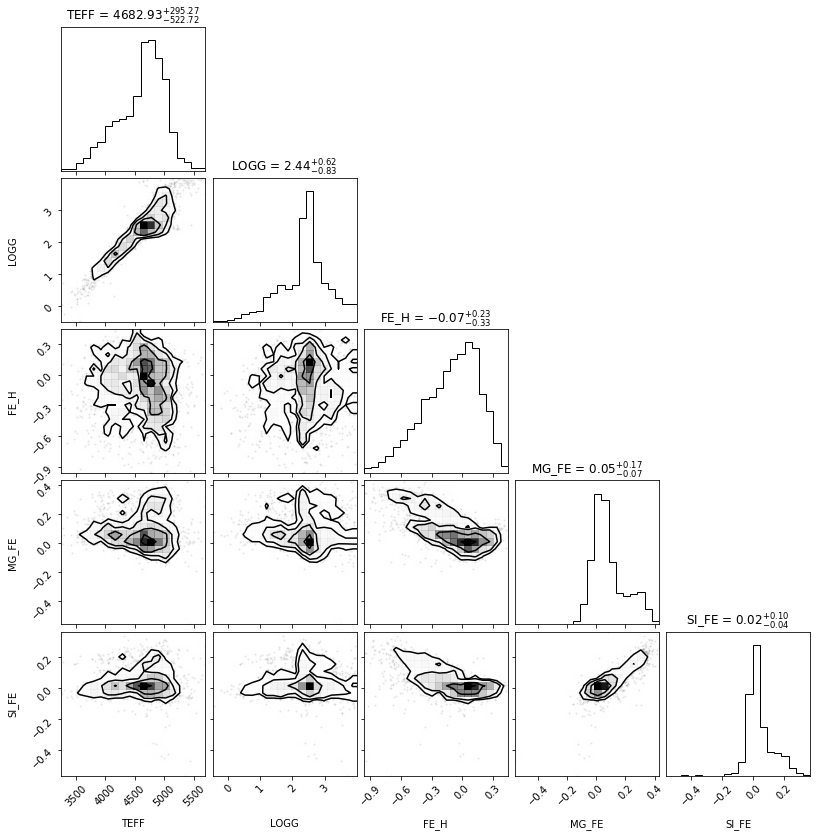

In [11]:
# visualize the target stars' distribution in label space using a corner plot
import corner

_ = corner.corner(new_data, labels=['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE'], show_titles=True)

In [12]:
# apply cuts to spectra data
keep = [obj in allStar_table['APOGEE_ID'] for obj in ids]

ids = np.array(ids)[keep]
fluxes = np.array(fluxes)[keep]
errors = np.array(errors)[keep]
bitmasks = np.array(bitmasks)[keep]

### Problem 3

In [13]:
# Use the apStar bitmasks to identify bad pixels in each spectrum 
# Set the uncertainty in these pixels to a large value
for i in range(1854):
    errors[i] = np.where((bitmasks[i] & 0b1000011111111) != 0, 1.e+10, errors[i])

### Problem 4

To “pseudo-continuum normalize” a spectrum means to divide out the pixels that are theoretically thought to be a part of the continuum, and not be impacted from absorption or emission. This is useful becuase it allows us to normalize the spectrum without removing the features that we will want to use in modeling the spectra. The difference between pseudo-continuum normalization and "true" continuum normalization is that pseudo normalization only normalizes based on select pixels while true normalization would normalize based on all of the pixels. 

In [14]:
# download the continuum_pixels_apogee.npz data
continuum_pixels = np.load('continuum_pixels_apogee.npz')
wavelengths = continuum_pixels['wavelength']
is_continuum = continuum_pixels['is_continuum']

# identify which wavelengths are in the continuum
continuum_wavelengths = np.round(wavelengths[is_continuum], 0)

In [15]:
import numpy.polynomial.chebyshev as cheb

In [16]:
# from Ness 2.3 chips are at (i) 15150-15800 ˚A, (ii) 15890-16430 ˚A and (iii) 16490 - 16950
chip_indexes = [236, 3276, 3687, 6106, 6370, 8361]

In [17]:
# identify which indexes of the data we should include in the continuum
continuum_indexes = [l in continuum_wavelengths for l in np.round(lambdas, decimals=0)]

In [18]:
# delete stars which do no match the same data structure as the other stars
# only run this cell once
fluxes = np.delete(fluxes, [89,117])
ids = np.delete(ids, [89,117])
errors = np.delete(errors, [89,117])
bitmasks = np.delete(bitmasks, [89,117])
allStar_table.remove_rows([89, 117])
new_data = np.delete(new_data, [89,117])

In [19]:
import numpy.polynomial.chebyshev as cheb

In [20]:
# Normalize all spectra and error arrays
chips = []
normalized_fluxes = []
normalized_errors = []
fits = []
keeps = []
for i in range(len(fluxes)):
    beg1, end1, beg2, end2, beg3, end3 = chip_indexes
    
    chip1 = (fluxes[i][beg1:end1]).astype(float)
    chip2 = (fluxes[i][beg2:end2]).astype(float)
    chip3 = (fluxes[i][beg3:end3]).astype(float)
    
    chip1_cont = chip1[continuum_indexes[beg1:end1]]
    chip2_cont = chip2[continuum_indexes[beg2:end2]]
    chip3_cont = chip3[continuum_indexes[beg3:end3]]
    
    errors1 = (errors[i][beg1:end1]).astype(float)
    errors2 = (errors[i][beg2:end2]).astype(float)
    errors3 = (errors[i][beg3:end3]).astype(float)
    
    errors1_cont = errors1[continuum_indexes[beg1:end1]]
    errors2_cont = errors2[continuum_indexes[beg2:end2]]
    errors3_cont = errors3[continuum_indexes[beg3:end3]]
    
    lambdas1 = (lambdas[beg1:end1]).astype(float)
    lambdas2 = (lambdas[beg2:end2]).astype(float)
    lambdas3 = (lambdas[beg3:end3]).astype(float)
    
    lambdas1_cont = lambdas1[continuum_indexes[beg1:end1]]
    lambdas2_cont = lambdas2[continuum_indexes[beg2:end2]]
    lambdas3_cont = lambdas3[continuum_indexes[beg3:end3]]
    
    fit1 = cheb.Chebyshev.fit(lambdas1_cont, chip1_cont, deg=2, w=errors1_cont**-2)
    fit2 = cheb.Chebyshev.fit(lambdas2_cont, chip2_cont, deg=2, w=errors2_cont**-2)
    fit3 = cheb.Chebyshev.fit(lambdas3_cont, chip3_cont, deg=2, w=errors3_cont**-2)
    
    f_norm1 = chip1/fit1(lambdas1)
    f_norm2 = chip2/fit2(lambdas2)
    f_norm3 = chip3/fit3(lambdas3)
    
    e_norm1 = errors1/fit1(lambdas1)
    e_norm2 = errors2/fit2(lambdas2)
    e_norm3 = errors3/fit3(lambdas3)
    
    chips += [[chip1, chip2, chip3]]
    normalized_fluxes += [np.concatenate((np.zeros(beg1), f_norm1, np.zeros(beg2-end1), f_norm2, \
                                        np.zeros(beg3-end2), f_norm3, np.zeros(len(lambdas)-end3)), axis=None)]
    normalized_errors += [np.concatenate((np.zeros(beg1), e_norm1, np.zeros(beg2-end1), e_norm2, \
                                          np.zeros(beg3-end2), e_norm3,np.zeros(len(lambdas)-end3)), axis=None)]
    fits += [np.concatenate((np.zeros(beg1), fit1(lambdas1), np.zeros(beg2-end1), fit2(lambdas2), \
                             np.zeros(beg3-end2), fit3(lambdas3), np.zeros(len(lambdas)-end3)), axis=None)]

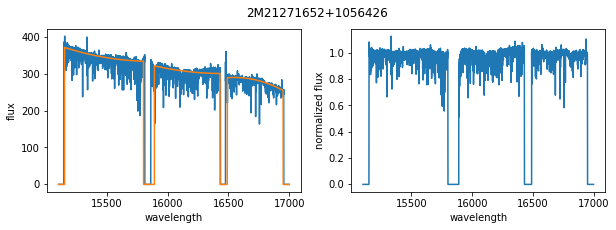

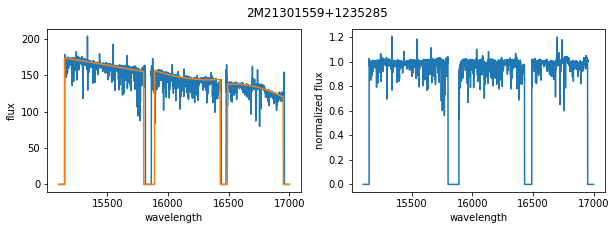

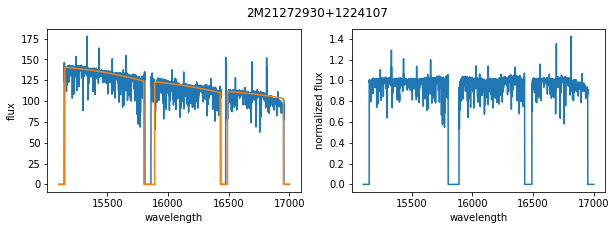

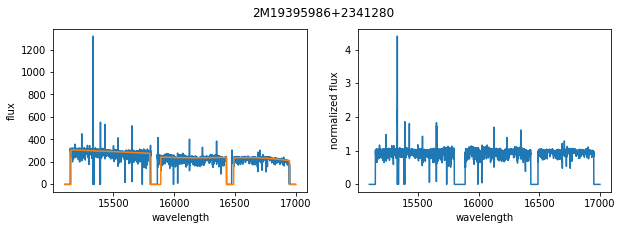

In [236]:
# Plot some example un-normalized spectrum, the derived pseudo-continuum, and the normalized spectrum.
for i in [2,58,468, 1392]:

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].plot(lambdas, fluxes[i])
    axs[0].plot(lambdas, fits[i])
    axs[0].set_xlabel('wavelength')
    axs[0].set_ylabel('flux')
    
    axs[1].plot(lambdas, normalized_fluxes[i])
    axs[1].set_xlabel('wavelength')
    axs[1].set_ylabel('normalized flux')
    
    fig.suptitle(ids[i])

### Problem 5

In [37]:
# designate 50% of spectra as the cross-validation set
import random
tr_indexes = random.sample(range(len(ids)), int(len(ids)/2))
tr_norm_fluxes = np.take(normalized_fluxes, tr_indexes, axis=0)
tr_ids = np.take(ids, tr_indexes)
tr_norm_errors = np.take(normalized_errors, tr_indexes, axis=0)
tr_bitmasks = np.take(bitmasks, tr_indexes, axis=0)

cv_norm_fluxes = np.delete(normalized_fluxes, tr_indexes, axis=0)
cv_ids = np.delete(ids, tr_indexes)
cv_norm_errors = np.delete(normalized_errors, tr_indexes, axis=0)
cv_bitmasks = np.delete(bitmasks, tr_indexes, axis=0)

tr_data = np.take(new_data, tr_indexes, axis=0)
cv_data = np.delete(new_data, tr_indexes, axis=0)


### Problem 6

### Part A:

Show that at a fixed value of s2λ, the spectral model for the pixel can be described by a linear equation Xθλ = fλ, where θλ is an array of model parameters for that pixel and X is a matrix that is the same for all pixels

$X^T = \begin{bmatrix}1 \\ T_{\rm eff} \\ \log g \\ [Fe/H] \\ [Mg/Fe] \\ [Si/Fe] \\ T_{\rm eff}\log g \\ T_{\rm eff}[Fe/H] \\ T_{\rm eff}[Mg/Fe] \\ T_{\rm eff}[Si/Fe] \\ \log g[Fe/H] \\ \log g[Mg/Fe] \\ \log g[Si/Fe] \\ [Fe/H][Mg/Fe] \\ [Fe/H][Si/Fe] \\ [Mg/Fe][Si/Fe] \\ T_{\rm eff}^2 \\ \log g^2 \\ [Fe/H]^2 \\ [Mg/Fe]^2 \\ [Si/Fe]^2\end{bmatrix}$

$\theta_\lambda = \begin{bmatrix}\theta_{\lambda,0} \\ \theta_{\lambda,1} \\ \theta_{\lambda,2} \\ \theta_{\lambda,3} \\ \theta_{\lambda,4} \\ \theta_{\lambda,5} \\ \theta_{\lambda,6} \\ \theta_{\lambda,7} \\ \theta_{\lambda,8} \\ \theta_{\lambda,9} \\ \theta_{\lambda,10} \\ \theta_{\lambda,11} \\ \theta_{\lambda,12} \\ \theta_{\lambda,13} \\ \theta_{\lambda,14} \\ \theta_{\lambda,15} \\ \theta_{\lambda,16} \\ \theta_{\lambda,17} \\ \theta_{\lambda,18} \\ \theta_{\lambda,19} \\ \theta_{\lambda,20} \end{bmatrix}$

There are 21 free parameters in $\theta_\lambda$

### Part B:

Gaussian Likelihood: $\Pi \frac{1}{\sqrt{2\pi\sigma^2}}e^\frac{data-model}{2\sigma^2}$

$\Pi \frac{1}{\sqrt{2\pi\sigma^2}}e^\frac{data-model}{2\sigma^2} \propto e^{-\chi^2} $

log likelihood $\propto -\chi^2 $

maximize log likelihood $\propto$ minimize $\chi^2$

$\chi^2 = \sum \frac{(data-X\theta_\lambda)^2}{{s_\lambda}^2}$


Log Likelihood of a Single Pixel: $\rm{ln}\ p(f_{n \lambda} \ |\ l_n, \theta_{\lambda}, s^2_{\lambda}) = - \frac{1}{2} \frac{[f_{n \lambda} - \theta_{\lambda}^{T} \dot\ \ell_{n}]^2}{\sigma_{n \lambda}^2 + s_\lambda^2}$ + $\rm{ln}\ (\sigma_{n \lambda}^2 + s_\lambda^2)$

The following code is largely adopted from the train_model.py file in Anna Ho's "The Cannon" github repo
https://github.com/annayqho/TheCannon

In [42]:
# function to find the optimal theta values for one pixel, given the fluxes, errors, and labels
def do_one_regression_at_fixed_scatter(lams, fluxes, ivars, lvec, scatter):
    '''
    Parameters
    ----------
    lams: numpy ndarray
        common wavelength array
    fluxes: numpy ndarray
        flux values for all stars at one pixel
    ivars: numpy ndarray
        inverse varience values for all stars at one pixel
    lvec: numpy ndarray
        the label vector
    scatter: float
        fixed scatter value
    
    Returns
    -------
    coeff: ndarray
        coefficients of the fit
    lTCinvl: ndarray
        inverse covariance matrix for fit coefficients
    chi: float
        chi-squared at best fit
    logdet_Cinv: float
        inverse of the log determinant of the cov matrix
    '''
    Cinv = ivars/(1+ivars*scatter**2)
    lTCinvl = np.dot(lvec.T, Cinv[:, None]*lvec)
    lTCinvf = np.dot(lvec.T, Cinv*fluxes)
    try:
        coeff = np.linalg.solve(lTCinvl, lTCinvf)
    except np.linalg.LinAlgError:
        print('np.linalg.linalg.LinAlgError, do_one_regression_at_fixed_scatter')
        print(lTCinvl, lTCinvf, lams, fluxes)
    if not np.all(np.isfinite(coeff)):
        raise RuntimeError('something is wrong with the coefficients')
    chi = np.sqrt(Cinv)*(fluxes-np.dot(lvec, coeff))
    logdet_Cinv = np.sum(np.log(Cinv))
    return (coeff, lTCinvl, chi, logdet_Cinv)

In [43]:
# function to calculate X vector with rescaled labels
def get_lvec(label_vals, pivots, scales):
    """
    Constructs a label vector for an arbitrary number of labels
    Assumes that our model is quadratic in the labels
    
    Comment: this is really slow, but we will only have to compute it once!
    Parameters
    ----------
    label_vals: numpy ndarray, shape (nstars, nlabels)
        labels 
    pivots: numpy ndarray, shape (nlabels, )
        offset we subtract from the label_vals
    scales: numpy ndarray, shape (nlabels, )
        scale we divide out of the label_vals
    Returns
    -------
    lvec: numpy ndarray
        label vector
        
    Notes
    --------
    lvec is now in units of the scaled labels! 
    """
    if len(label_vals.shape) == 1:
        label_vals = np.array([label_vals])
    nlabels = label_vals.shape[1]
    nstars = label_vals.shape[0]
    # specialized to second-order model
    linear_offsets = (label_vals - pivots[None, :]) / scales[None, :]
    quadratic_offsets = np.array([np.outer(m, m)[np.triu_indices(nlabels)]
                                  for m in (linear_offsets)])
    ones = np.ones((nstars, 1))
    lvec = np.hstack((ones, linear_offsets, quadratic_offsets))
    return lvec

In [41]:
# function to get pivots and scales of label values in order to be used in get_lvec to rescale labels
def get_pivots_and_scales(label_vals):
    '''
    function scales the labels 
    '''
    qs = np.percentile(label_vals, (2.5, 50, 97.5), axis=0)
    pivots = qs[1]
    scales = (qs[2] - qs[0])/4.
    
    return pivots, scales

In [140]:
# calculate label vector X for all of the training labels
all_label_vals = tr_data
p,s = get_pivots_and_scales(all_label_vals)
all_lvec = get_lvec(all_label_vals, p, s)

In [45]:
# test on a single pixel

#fluxes at pixel 300
f_300 = []
for f in tr_norm_fluxes:
    f_300 += [f[300]]
f_300 = np.array(f_300)

#ivars at pixel 0
ivars_300 = []
for e in tr_norm_errors:
    ivars_300 += [1/e[300]]
ivars_300 = np.array(ivars_300)

In [46]:
#test on 300th pixel

# coeff: coefficients of the fit, lTCinvl: inverse covariance matrix for fit coefficients, chi: chi-squared at 
# best fit, logdet_Cinv: inverse of the log determinant of the cov matrix
do_one_regression_at_fixed_scatter(lambdas, f_300, ivars_300, all_lvec, 0.25)

(array([ 7.64676477e-01,  6.54060468e-03, -1.46337406e-02,  5.38048073e-04,
        -6.90127815e-03,  1.01725625e-02, -3.86562472e-03,  9.86828329e-03,
         4.19751941e-03, -1.65809065e-03,  2.36962932e-03, -6.43130855e-03,
         2.89440100e-03,  7.66939834e-03, -6.99978339e-03,  3.69153290e-03,
         2.07051657e-02, -7.37517431e-03,  5.49146121e-03, -8.06702131e-03,
         1.53641333e-03]),
 array([[ 1.29501757e+04, -2.69639249e+03, -1.27350812e+03,
         -1.64964232e+03,  3.25324175e+03,  2.89381863e+03,
          1.46306855e+04,  1.21319410e+04, -5.50745164e+02,
         -8.71190330e+02,  7.65418971e+02,  1.19736401e+04,
          1.25603483e+03, -6.26208307e+02,  2.06846087e+02,
          1.44620695e+04, -9.43365570e+03, -8.40139077e+03,
          1.50518592e+04,  1.23996530e+04,  1.51448338e+04],
        [-2.69639249e+03,  1.46306855e+04,  1.21319410e+04,
         -5.50745164e+02, -8.71190330e+02,  7.65418971e+02,
         -1.79917130e+04, -1.48294996e+04, -3.024382

In [47]:
# grid of scatter values for each pixel
ln_scatter_vals = np.arange(np.log(.0001), 0, 0.5)

# step through scatter grid
chis_eval = np.zeros_like(ln_scatter_vals)
for jj, s in enumerate(ln_scatter_vals):
    # solve linear equation for theta vector (coeff) 
    coeff, lTCinvl, chi, logdet_Cinv = do_one_regression_at_fixed_scatter( \
                                        lambdas, f_300, ivars_300, all_lvec, np.exp(s))
    # calculate chi squared value 
    #(effectively the likelihood since minimizing chi-squared is equivalent to maximizing likelihood)
    chis_eval[jj] = np.sum(chi*chi) - logdet_Cinv

# find the lowest chi squared value (highest likelihood value)
lowest = np.argmin(chis_eval)
# find corresponding scatter value
optimal_scatter = np.exp(ln_scatter_vals[lowest])
# find corresponding optimal theta vector
r = do_one_regression_at_fixed_scatter(lambdas, f_300, ivars_300, all_lvec, optimal_scatter)
optimal_theta = r[0]

In [48]:
optimal_theta

array([ 7.56771978e-01,  4.11939890e-03, -1.06413572e-02,  4.73328428e-03,
       -7.42376416e-03,  7.89705614e-03,  1.01005367e-03,  8.82562051e-03,
        9.01903469e-03,  3.92811018e-04,  3.92216366e-03, -1.01208748e-02,
       -5.67701865e-04,  5.30831085e-03, -7.59760583e-03,  3.75710883e-03,
        1.70796054e-02, -6.44468091e-03,  4.81615214e-03, -8.27904341e-03,
        2.87807909e-03])

In [49]:
optimal_scatter

0.040342879349273546

In [50]:
min(chis_eval)

-3069.7336441157395

### Part C:

In [51]:
# function to do the above procedure, so that we can repeat for all pixels
def do_one_regression(lams, fluxes, ivars, lvec):
    """
    Optimizes to find the scatter associated with the best-fit model.
    This scatter is the deviation between the observed spectrum and the model.
    It is wavelength-independent, so we perform this at a single wavelength.
    Input
    -----
    lams: numpy ndarray
        the common wavelength array
    fluxes: numpy ndarray
        pixel intensities
    ivars: numpy ndarray
        inverse variances associated with pixel intensities
    lvec = numpy ndarray 
        the label vector
    Output
    -----
    output of do_one_regression_at_fixed_scatter
    """
    ln_scatter_vals = np.arange(np.log(.0001), 0, 0.5)

    chis_eval = np.zeros_like(ln_scatter_vals)
    for jj, s in enumerate(ln_scatter_vals):
        coeff, lTCinvl, chi, logdet_Cinv = do_one_regression_at_fixed_scatter( \
                                            lambdas, fluxes, ivars, lvec, np.exp(s))
        chis_eval[jj] = np.sum(chi*chi) - logdet_Cinv
        
    if np.any(np.isnan(chis_eval)):
        best_scatter = np.exp(ln_scatter_vals[-1])
        _r = do_one_regression_at_fixed_scatter(lams, fluxes, ivars, lvec, best_scatter)
        return _r + (best_scatter, )
    
    lowest = np.argmin(chis_eval)
    if (lowest==0) or (lowest == len(ln_scatter_vals)-1):
        best_scatter = np.exp(ln_scatter_vals[lowest])
        _r = do_one_regression_at_fixed_scatter(lams, fluxes, ivars, lvec, best_scatter)
        return _r + (best_scatter, )
    
    best_scatter = np.exp(ln_scatter_vals[lowest])
    _r = do_one_regression_at_fixed_scatter(lams, fluxes, ivars, lvec, best_scatter)
    return _r + (best_scatter, )

In [52]:
# test above function on a single pixel
do_one_regression(lambdas, f_300, ivars_300, all_lvec)

(array([ 7.56771978e-01,  4.11939890e-03, -1.06413572e-02,  4.73328428e-03,
        -7.42376416e-03,  7.89705614e-03,  1.01005367e-03,  8.82562051e-03,
         9.01903469e-03,  3.92811018e-04,  3.92216366e-03, -1.01208748e-02,
        -5.67701865e-04,  5.30831085e-03, -7.59760583e-03,  3.75710883e-03,
         1.70796054e-02, -6.44468091e-03,  4.81615214e-03, -8.27904341e-03,
         2.87807909e-03]),
 array([[ 139274.99721076,  -32023.76332327,  -17505.7596768 ,
          -13418.08463574,   26378.92707546,   24701.11130537,
          161240.28992645,  133543.4710305 ,   -5585.79254164,
          -10909.64190646,    7818.63453333,  129633.72349742,
           12647.37179749,   -6620.59507565,    4313.29109899,
          145297.14399885,  -92189.99644481,  -83148.85595694,
          148085.04164261,  121220.23168397,  151083.65146345],
        [ -32023.76332327,  161240.28992645,  133543.4710305 ,
           -5585.79254164,  -10909.64190646,    7818.63453333,
         -206804.34679443

In [53]:
# repeat for all pixels
optimal_scatters = [0]*(chip_indexes[0])
optimal_thetas = [np.zeros(21)]*(chip_indexes[0])

#chip1
for i in range(chip_indexes[0], chip_indexes[1]):
    f_i = []
    for f in tr_norm_fluxes:
        f_i += [f[i]]
    f_i = np.array(f_i)

    ivars_i = []
    for e in tr_norm_errors:
        ivars_i += [1/e[i]]
    ivars_i = np.array(ivars_i)
    
    coeff, lTCinvl, chi, logdet_Cinv, optimal_s = do_one_regression(lambdas, f_i, ivars_i, all_lvec)
    optimal_scatters += [optimal_s]
    optimal_thetas += [coeff]

optimal_scatters += [0]*(chip_indexes[2]-chip_indexes[1])
optimal_thetas += [np.zeros(21)]*(chip_indexes[2]-chip_indexes[1])
    
#chip2
for i in range(chip_indexes[2], chip_indexes[3]):
    f_i = []
    for f in tr_norm_fluxes:
        f_i += [f[i]]
    f_i = np.array(f_i)

    ivars_i = []
    for e in tr_norm_errors:
        ivars_i += [1/e[i]]
    ivars_i = np.array(ivars_i)
    
    coeff, lTCinvl, chi, logdet_Cinv, optimal_s = do_one_regression(lambdas, f_i, ivars_i, all_lvec)
    optimal_scatters += [optimal_s]
    optimal_thetas += [coeff]

optimal_scatters += [0]*(chip_indexes[4]-chip_indexes[3])
optimal_thetas += [np.zeros(21)]*(chip_indexes[4]-chip_indexes[3])
    
#chip3
for i in range(chip_indexes[4], chip_indexes[5]):
    f_i = []
    for f in tr_norm_fluxes:
        f_i += [f[i]]
    f_i = np.array(f_i)

    ivars_i = []
    for e in tr_norm_errors:
        ivars_i += [1/e[i]]
    ivars_i = np.array(ivars_i)
    
    coeff, lTCinvl, chi, logdet_Cinv, optimal_s = do_one_regression(lambdas, f_i, ivars_i, all_lvec)
    optimal_scatters += [optimal_s]
    optimal_thetas += [coeff]

optimal_scatters += [0]*(len(lambdas)-chip_indexes[5])
optimal_thetas += [np.zeros(21)]*(len(lambdas)-chip_indexes[5])

The total number of free parameters in my spectral model is 21 * number of pixels = 21*8575 = 180,075

### Part D:

In [54]:
# function that takes a label vector for an arbitrary star and uses the model to predict the normalized spectrum.
def predict_spectra(lvec_one_star):
    f = []
    for i in range(len(optimal_thetas)):
        f.append(np.dot(lvec_one_star,optimal_thetas[i]) + optimal_scatters[i])
    return f 

### Problem 7

In [51]:
# see which set star '2M03533659+2512012' is in
(tr_ids=='2M03533659+2512012').any()

True

In [52]:
# find index of star '2M03533659+2512012'
np.where(tr_ids=='2M03533659+2512012')

(array([338]),)

In [54]:
# calculate model spectrum predicted for labels of '2M03533659+2512012'
model_338 = predict_spectra(all_lvec[338])

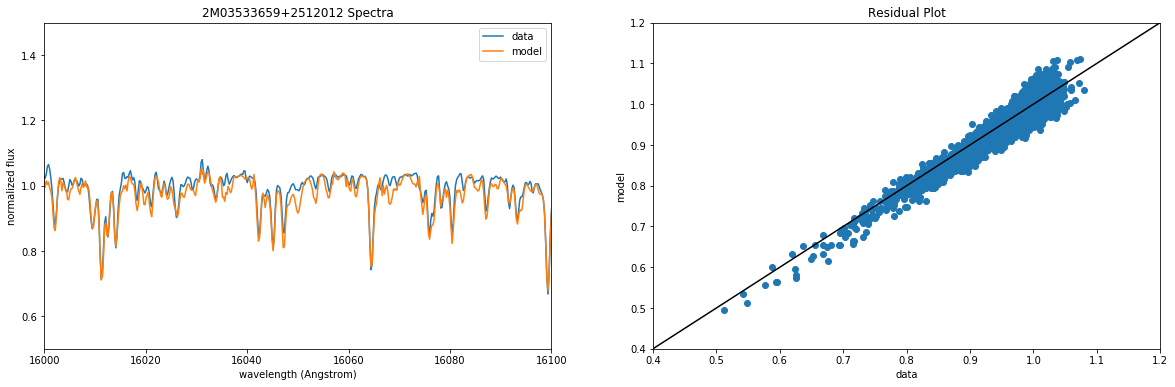

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

#overplot the normalized spectrum with the model spectrum
axs[0].plot(lambdas, tr_norm_fluxes[338], label='data')
axs[0].plot(lambdas, model_338, label='model')
axs[0].set_xlim(16000,16100) # Show only the wavelength range from 16000 to 161000 Angstroms
axs[0].set_ylim(0.5,1.5)
axs[0].set_title('2M03533659+2512012 Spectra')
axs[0].legend()
axs[0].set_xlabel('wavelength (Angstrom)')
axs[0].set_ylabel('normalized flux')

# also plot residuals to see how well the model linesup with the data
axs[1].scatter(tr_norm_fluxes[338], model_338)
axs[1].set_xlabel('data')
axs[1].set_ylabel('model')
axs[1].plot([0,2], [0,2], color='k')
axs[1].set_xlim(0.4,1.2)
axs[1].set_ylim(0.4,1.2)
axs[1].set_title('Residual Plot')

plt.show()

The data and model spectra look almost identical.

### Problem 8

In [56]:
# Label Vector Stucture:
# [0]1, [1]TEFF, [2]LOGG, [3]FE_H, [4]MG_FE, [5]SI_FE, [6]TEFF**2, [7]TEFF*LOGG, [8]TEFF*FE_H, [9]TEFF*MG_FE, 
# [10]TEFF*SI_FE, [11]LOGG**2, [12]LOGG*FE_H, [13]LOGG*MG_FE, [14]LOGG*SI_FE, [15]FE_H**2, [16]FE_H*MG_FE, 
# [17]FE_H*SI_FE, [18]MG_FE**2, [19]MG_FE*SI_FE, [20]SI_FE**2 

In [55]:
# function to calculate a varied label vector for a given label

import copy

def vary_one_label(lvec, label, delta):
    new_lvec = copy.deepcopy(lvec)
    if label == 'teff':
        new_lvec[1] = lvec[1]*delta
        new_lvec[6] = lvec[6]*delta*delta
        new_lvec[7] = lvec[7]*delta
        new_lvec[8] = lvec[8]*delta
        new_lvec[9] = lvec[9]*delta
        new_lvec[10] = lvec[10]*delta
    if label == 'logg':
        new_lvec[2] = lvec[2]*delta
        new_lvec[7] = lvec[7]*delta
        new_lvec[11] = lvec[11]*delta*delta
        new_lvec[12] = lvec[12]*delta
        new_lvec[13] = lvec[13]*delta
        new_lvec[14] = lvec[14]*delta
    if label == 'fe_h':
        new_lvec[3] = lvec[3]*delta
        new_lvec[8] = lvec[8]*delta
        new_lvec[12] = lvec[12]*delta
        new_lvec[15] = lvec[15]*delta*delta
        new_lvec[16] = lvec[16]*delta
        new_lvec[17] = lvec[17]*delta
    if label == 'mg_fe':
        new_lvec[4] = lvec[4]*delta
        new_lvec[9] = lvec[9]*delta
        new_lvec[13] = lvec[13]*delta
        new_lvec[16] = lvec[16]*delta
        new_lvec[18] = lvec[18]*delta*delta
        new_lvec[19] = lvec[19]*delta
    if label == 'si_fe':
        new_lvec[5] = lvec[5]*delta
        new_lvec[10] = lvec[10]*delta
        new_lvec[14] = lvec[14]*delta
        new_lvec[17] = lvec[17]*delta
        new_lvec[19] = lvec[19]*delta
        new_lvec[20] = lvec[20]*delta*delta
    return new_lvec

In [67]:
# function to calculate df/dl given a varied label vector
def df_dl(lvec, label, delta):
    d_lvec = vary_one_label(lvec, label, delta)
    df = np.where(np.array(predict_spectra(d_lvec))!=0, np.array(model_338) / np.array(predict_spectra(d_lvec)), 1)
    return df

d_teff = df_dl(all_lvec[338], 'teff', 0.1)
d_logg = df_dl(all_lvec[338], 'logg', 0.1)
d_fe_h = df_dl(all_lvec[338], 'fe_h', 0.1)
d_mg_fe = df_dl(all_lvec[338], 'mg_fe', 0.1)
d_si_fe = df_dl(all_lvec[338], 'si_fe', 0.1)

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


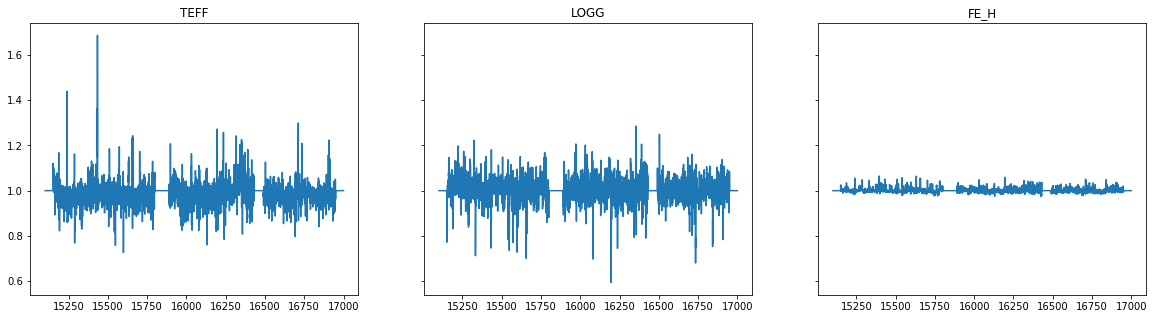

In [68]:
# plot the gradient spectrum for Teff, logg, and Fe/H
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

axs[0].plot(lambdas, d_teff)
axs[0].set_title('TEFF')

axs[1].plot(lambdas, d_logg)
axs[1].set_title('LOGG')

axs[2].plot(lambdas, d_fe_h)
axs[2].set_title('FE_H')

plt.show()

Text(0.5, 1.0, 'SI_FE')

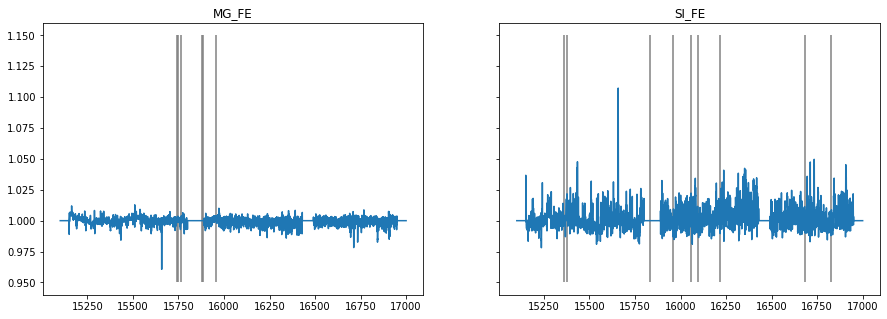

In [71]:
# plot the gradient spectrum for Mg/Fe and Si/Fe, including the locations of strong known Si and Mg lines
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

axs[0].plot(lambdas, d_mg_fe)
mg_lines = [15740.716, 15748.9, 15765.8, 15879.5, 15886.2, 15954.477]
axs[0].vlines(mg_lines, ymin=0.95, ymax=1.15, color='grey')
axs[0].set_title('MG_FE')

axs[1].plot(lambdas, d_si_fe)
si_lines = [15361.161, 15376.831, 15833.602,15960.063,16060.009, 16094.787, 16215.670, 16680.770, 16828.159]
axs[1].vlines(si_lines, ymin=0.95, ymax=1.15, color='grey')
axs[1].set_title('SI_FE')

The regions of the spectrum where the gradient is large do not seem to correspond to known absorption lines. However, I would expect them to, so there might be something wrong with my calculation of the gradient or with my model. 

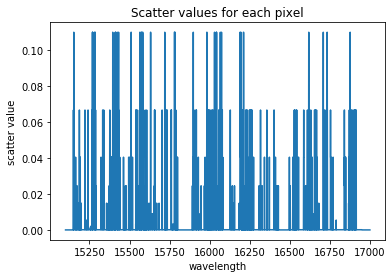

In [239]:
# plot the scatter vs. wavelength
plt.plot(lambdas, optimal_scatters)
plt.xlabel('wavelength')
plt.ylabel('scatter value')
plt.title('Scatter values for each pixel')
plt.show()

In [76]:
# find wavelengths with large scatter
large_scatter = lambdas[optimal_scatters == max(optimal_scatters)]

In [81]:
# see if wavelengths with large scatter correspond to Mg absorption lines 
[line in np.round(large_scatter,0) for line in np.round(mg_lines,0)]

[False, False, False, False, False, False]

In [84]:
# see if wavelengths with large scatter correspond to Si absorption lines 
[line in np.round(large_scatter,0) for line in np.round(si_lines,0)]

[False, False, False, False, False, False, False, False, False]

### Problem 9

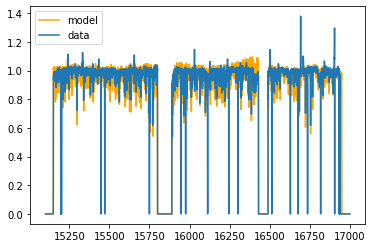

In [92]:
# get label vector X for data in cross-validation set
cv_label_vals = cv_data
cv_lvec = get_lvec(cv_label_vals, p, s)

# plot an example spectrum in the validation set to check that the model is somewhat correct on non-training data
plt.plot(lambdas, predict_spectra(cv_lvec[0]), label='model', color='orange')
plt.plot(lambdas, cv_norm_fluxes[0], label='data')
plt.legend()

In [56]:
# function to get the label vector of a single star
def get_one_lvec(label_vals, pivots, scales):
    if len(label_vals.shape) == 1:
        label_vals = np.array([label_vals])
    nlabels = label_vals.shape[1]
    nstars = label_vals.shape[0]
    # specialized to second-order model
    linear_offsets = (label_vals - pivots) / scales
    quadratic_offsets = np.array([np.outer(m, m)[np.triu_indices(nlabels)]
                                  for m in (linear_offsets)])
    ones = np.ones((nstars, 1))
    lvec = np.hstack((ones, linear_offsets, quadratic_offsets))
    return lvec

In [57]:
# function which takes thetas and labels and returns the model spectra
def model_func(thetas, teff, logg, fe_h, mg_fe, si_fe):
    '''thetas is optimal thetas array and label_data is the label values for one star
    returns spectra for one star'''
    label_data = np.array([teff, logg, fe_h, mg_fe, si_fe])
    #p,s = get_pivots_and_scales(label_data)
    lvec = get_one_lvec(label_data, p, s)
    model = predict_spectra(lvec)
    return np.concatenate(model)

In [96]:
# use curve_fit to find the best point in label-space for an example spectrum 
# (where the spectrum predicted by the model best matches the observed spectrum)
from scipy.optimize import curve_fit
popt_0, pcov_0 = curve_fit(model_func, optimal_thetas, cv_norm_fluxes[0], method='trf', p0=np.mean(tr_data, axis=0))

In [97]:
# apogee labels
cv_data[0]

array([ 4.7449141e+03,  2.4329338e+00, -7.2163545e-02,  4.5521699e-02,
        5.0551996e-02], dtype=float32)

In [98]:
# curve_fit labels
popt_0

array([ 5.63057031e+03,  3.49681825e+00, -6.35920892e-01, -1.18130730e-01,
       -2.19798098e-02])

In [101]:
# Find the best label vector for each spectrum in the validation set
optimal_labels = []
for i in range(len(cv_norm_fluxes)):
    try:
        popt, pcov = curve_fit(model_func, optimal_thetas, cv_norm_fluxes[i], method='trf', p0=np.mean(tr_data, axis=0))
        optimal_labels += [popt]
    except RuntimeError:
        print('Optimal parameters not found: The maximum number of function evaluations is exceeded.')
        print(i)

Optimal parameters not found: The maximum number of function evaluations is exceeded.
66
Optimal parameters not found: The maximum number of function evaluations is exceeded.
87
Optimal parameters not found: The maximum number of function evaluations is exceeded.
205
Optimal parameters not found: The maximum number of function evaluations is exceeded.
311
Optimal parameters not found: The maximum number of function evaluations is exceeded.
342
Optimal parameters not found: The maximum number of function evaluations is exceeded.
422
Optimal parameters not found: The maximum number of function evaluations is exceeded.
458
Optimal parameters not found: The maximum number of function evaluations is exceeded.
544
Optimal parameters not found: The maximum number of function evaluations is exceeded.
612
Optimal parameters not found: The maximum number of function evaluations is exceeded.
698
Optimal parameters not found: The maximum number of function evaluations is exceeded.
720
Optimal para

In [103]:
optimal_labels_not_found = [66,87,205,311,342,422,458,544,612,698,720,755,796,858,884]
cv_data_found_labels = [cv_data[i] for i in range(len(cv_data)) if i not in optimal_labels_not_found]

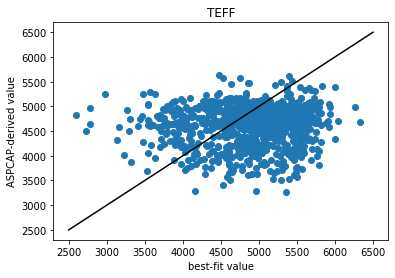

In [112]:
#compare, for each of the five labels, the best-fit value obtained by the above procedure to the ASPCAP-derived 
#    value in the allStar catalog for the validation set

# Teff
plt.scatter([i[0] for i in optimal_labels], [i[0] for i in cv_data_found_labels])
plt.plot([2500,6500],[2500,6500], color='k')
plt.xlabel('best-fit value')
plt.ylabel('ASPCAP-derived value')
plt.title('TEFF')
plt.show()

In [107]:
# there seems to be no correlation, something is wrong with my model

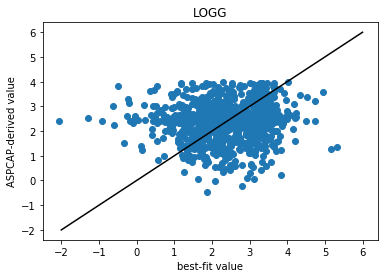

In [113]:
# logg
plt.scatter([i[1] for i in optimal_labels], [i[1] for i in cv_data_found_labels])
plt.plot([-2,6],[-2,6], color='k')
plt.xlabel('best-fit value')
plt.ylabel('ASPCAP-derived value')
plt.title('LOGG')
plt.show()

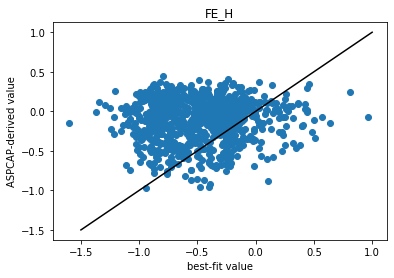

In [118]:
#Fe/H
plt.scatter([i[2] for i in optimal_labels], [i[2] for i in cv_data_found_labels])
plt.plot([-1.5,1],[-1.5,1], color='k')
plt.xlabel('best-fit value')
plt.ylabel('ASPCAP-derived value')
plt.title('FE_H')
plt.show()

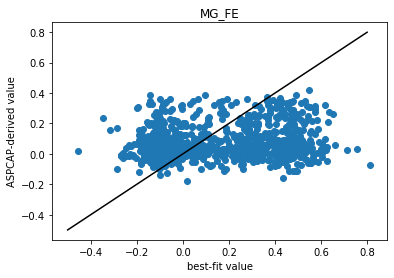

In [121]:
#Mg/Fe
plt.scatter([i[3] for i in optimal_labels], [i[3] for i in cv_data_found_labels])
plt.plot([-0.5,0.8],[-0.5,0.8], color='k')
plt.xlabel('best-fit value')
plt.ylabel('ASPCAP-derived value')
plt.title('MG_FE')
plt.show()

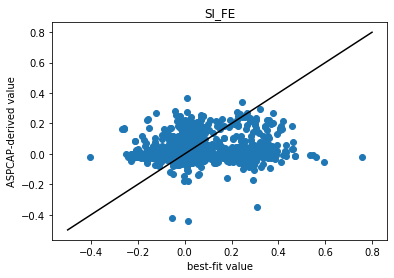

In [123]:
#Si/Fe
plt.scatter([i[4] for i in optimal_labels], [i[4] for i in cv_data_found_labels])
plt.plot([-0.5,0.8],[-0.5,0.8], color='k')
plt.xlabel('best-fit value')
plt.ylabel('ASPCAP-derived value')
plt.title('SI_FE')
plt.show()

In [ ]:
# I'm not happy with my model's performance, 
#    but I did not have the time to figure out what the problem was and fix it

### Problem 11

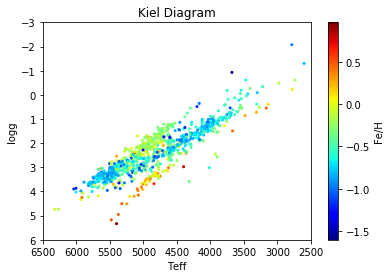

In [181]:
# plot a Kiel diagram for all the stars in the validation set, coloring points by Fe/H
plt.scatter([i[0] for i in optimal_labels], [i[1] for i in optimal_labels], c=[i[2] for i in optimal_labels], \
            s=4, cmap='jet')
cbar = plt.colorbar()
cbar.set_label('Fe/H')
plt.ylabel('logg')
plt.xlabel('Teff')
plt.xlim(6500, 2500)
plt.ylim(6,-3)
plt.title('Kiel Diagram')
plt.show()

The shape of my graph looks similar to the shape of the callibrated Kiel diagram in Holtzman et al.
The Fe/H trend does not seem to exactly match the one in Holtzman et al.

In [166]:
import read_mist_models

# Download a 6 Gyr-old MIST isochrone of solar metallicity (Fe/H=0)
isocmd0 = read_mist_models.ISOCMD('MIST_0.iso.cmd')

# Download a 6 Gyr-old MIST isochrone with Fe/H= -1
isocmd1 = read_mist_models.ISOCMD('MIST_1.iso.cmd')

Reading in: MIST_0.iso.cmd
Reading in: MIST_1.iso.cmd


In [167]:
# get Teff and logg data from isochrones

isochrone0_Teff = 10**np.array([i[4] for i in isocmd0.isocmds[0]])
isochrone0_logg = np.array([i[5] for i in isocmd0.isocmds[0]])

isochrone1_Teff = 10**np.array([i[4] for i in isocmd1.isocmds[0]])
isochrone1_logg = np.array([i[5] for i in isocmd1.isocmds[0]])

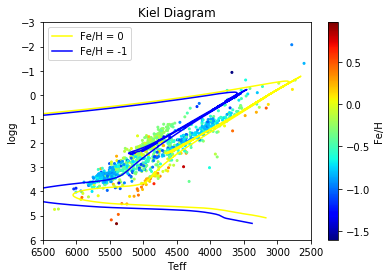

In [183]:
# overplot the isochrones to the Kiel diagram
plt.plot(isochrone0_Teff, isochrone0_logg, c='yellow', label='Fe/H = 0')
plt.plot(isochrone1_Teff, isochrone1_logg, c='blue', label='Fe/H = -1')
plt.legend()

plt.scatter([i[0] for i in optimal_labels], [i[1] for i in optimal_labels], c=[i[2] for i in optimal_labels], \
            s=4, cmap='jet')
cbar = plt.colorbar()
cbar.set_label('Fe/H')
plt.ylabel('logg')
plt.xlabel('Teff')
plt.xlim(6500, 2500)
plt.ylim(6,-3)
plt.title('Kiel Diagram')
plt.show()

The [Fe/H]-trend in the isochrones does seem to agree with that found in my fitting: there are more yellow stars near the yellow line and blue stars near the blue line

### Problem 12

In [65]:
# get data from mystery spectrum file
mystery_file = pf.open('mystery_spec_wiped.fits')
mystery_header = mystery_file[0].header
mystery_id = mystery_header['OBJID']
mystery_spectra = mystery_file[1].data
mystery_error = mystery_file[2].data
mystery_bitmask = mystery_file[3].data

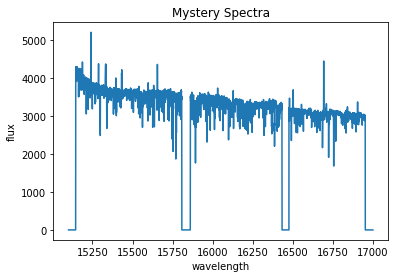

In [69]:
# plot mystery spectrum to check it out and see wassup
plt.plot(lambdas, mystery_spectra)
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.title('Mystery Spectra')
plt.show()

In [79]:
# normalize fluxes and errors from mystery spectrum

beg1, end1, beg2, end2, beg3, end3 = chip_indexes
    
chip1 = (mystery_spectra[beg1:end1]).astype(float)
chip2 = (mystery_spectra[beg2:end2]).astype(float)    
chip3 = (mystery_spectra[beg3:end3]).astype(float)
    
chip1_cont = chip1[continuum_indexes[beg1:end1]]
chip2_cont = chip2[continuum_indexes[beg2:end2]]
chip3_cont = chip3[continuum_indexes[beg3:end3]]
    
errors1 = (mystery_error[beg1:end1]).astype(float)
errors2 = (mystery_error[beg2:end2]).astype(float)
errors3 = (mystery_error[beg3:end3]).astype(float)
    
errors1_cont = errors1[continuum_indexes[beg1:end1]]
errors2_cont = errors2[continuum_indexes[beg2:end2]]
errors3_cont = errors3[continuum_indexes[beg3:end3]]
    
lambdas1 = (lambdas[beg1:end1]).astype(float)
lambdas2 = (lambdas[beg2:end2]).astype(float)
lambdas3 = (lambdas[beg3:end3]).astype(float)
    
lambdas1_cont = lambdas1[continuum_indexes[beg1:end1]]
lambdas2_cont = lambdas2[continuum_indexes[beg2:end2]]
lambdas3_cont = lambdas3[continuum_indexes[beg3:end3]]
    
fit1 = cheb.Chebyshev.fit(lambdas1_cont, chip1_cont, deg=2, w=errors1_cont**-2)
fit2 = cheb.Chebyshev.fit(lambdas2_cont, chip2_cont, deg=2, w=errors2_cont**-2)
fit3 = cheb.Chebyshev.fit(lambdas3_cont, chip3_cont, deg=2, w=errors3_cont**-2)
    
f_norm1 = chip1/fit1(lambdas1)
f_norm2 = chip2/fit2(lambdas2)
f_norm3 = chip3/fit3(lambdas3)
    
e_norm1 = errors1/fit1(lambdas1)
e_norm2 = errors2/fit2(lambdas2)
e_norm3 = errors3/fit3(lambdas3)
    
chips = [chip1, chip2, chip3]
norm_spectra = np.concatenate((np.zeros(beg1), f_norm1, np.zeros(beg2-end1), f_norm2, np.zeros(beg3-end2), f_norm3, np.zeros(len(lambdas)-end3)), axis=None)
norm_errors = np.concatenate((np.zeros(beg1), e_norm1, np.zeros(beg2-end1), e_norm2, np.zeros(beg3-end2), e_norm3, np.zeros(len(lambdas)-end3)), axis=None)
fit = np.concatenate((np.zeros(beg1), fit1(lambdas1), np.zeros(beg2-end1), fit2(lambdas2), np.zeros(beg3-end2), fit3(lambdas3), np.zeros(len(lambdas)-end3)), axis=None)


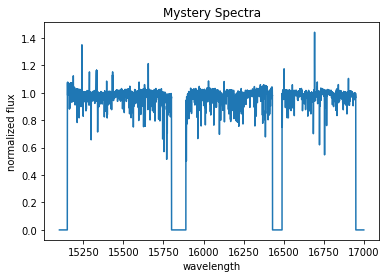

In [81]:
# plot normalized mystery flux spectrum to check that it normalized correctly
plt.plot(lambdas, norm_spectra)
plt.xlabel('wavelength')
plt.ylabel('normalized flux')
plt.title('Mystery Spectra')
plt.show()

In [84]:
# test on scipy optimize curvefit
popt_mystery, pcov_mystery = curve_fit(model_func, optimal_thetas, norm_spectra, method='trf', p0=np.mean(tr_data, axis=0))

In [85]:
popt_mystery

array([ 4.69073148e+03,  2.43525510e+00, -3.78659694e-01,  4.72936853e-01,
       -1.70968778e-01])

In [68]:
import pymc3 as pm
import theano

/Users/Jackie/opt/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:697: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  "DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [111]:
# define likelihood function for MCMC
def ln_likelihood(thetas, labels, scatters):
    teff, logg, fe_h, mg_fe, si_fe = labels
    y_hat = model_func(thetas, teff, logg, fe_h, mg_fe, si_fe)
    gauss = -0.5*((norm_spectra - y_hat)**2 / (np.array(scatters)**2 + norm_errors**2)) \
            - 0.5*np.log(np.array(scatters)**2 + norm_errors**2)
    return np.sum(np.nan_to_num(gauss))

In [112]:
# test likelihood function to make sure it runs correctly
ln_likelihood(optimal_thetas, popt_mystery, optimal_scatters)

-88868.36468513623

In [121]:
# Wrap spectral model in MCMC using pymc3
with pm.Model() as model:
    
    # define priors
    thetas = pm.Uniform("thetas", lower=-0.5, upper=1.5)
    labels = pm.Uniform("labels", lower=-50, upper=5000)
    scatters = pm.Uniform("scatters", lower=0, upper=0.5)
    
    # define the log-likelihood function
    # note that numpy doesn't play nicely with PyMC3, so you should use their built in math functions
    ln_likelihood(thetas, labels, scatters)
    
    step = pm.NUTS()
    # now set up the model to run
    # default of PyMC3 is to use the no-turn sampler (NUTS)
    
    # pm.sample will run the sampler and store output in 'trace' 
    trace = pm.sample(draws=1000, tune=200, chains=2, cores=2, step=step)

TypeError: TensorType does not support iteration. Maybe you are using builtins.sum instead of theano.tensor.sum? (Maybe .max?)

In [ ]:
# did not have time to figure out "black box" likelihood function from the linked tutorial

### Problem 13

In [132]:
# for the animations, I will use the label data from the first star in my training set (2M19464535+2434126)

In [136]:
# set labels to be fixed
teff, logg, fe_h, mg_fe, si_fe = tr_data[0]

In [141]:
# original model spectra with fixed labels
spectra = model_func(optimal_thetas, teff, logg, fe_h, mg_fe, si_fe)

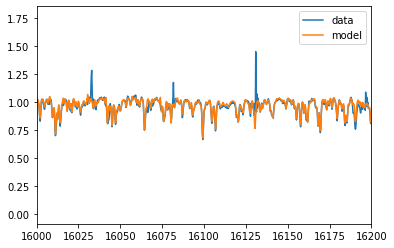

In [145]:
# overplot original model spectra with data to see what the fixed spectra looks like
plt.plot(lambdas, tr_norm_fluxes[0], label='data')
plt.plot(lambdas, spectra, label='model')
plt.xlim(16000, 16200)
plt.legend()
plt.show()

In [152]:
from matplotlib.animation import FFMpegWriter

In [228]:
metadata13 = dict(title="Q13 Animation", artist='Jackie')
writer13 = FFMpegWriter(fps=15, metadata=metadata13)
fig13 = plt.figure(dpi=200)

<Figure size 1200x800 with 0 Axes>

In [229]:
# vary the Fe/H metallicity from -1 to 0.5 w/ step size of 0.1 and create animation

with writer13.saving(fig13, "q13_animation.mp4", dpi=200):
    for fe_h in np.round(np.linspace(-1,0.5,16),1):
        spectra = model_func(optimal_thetas, teff, logg, fe_h, mg_fe, si_fe)
        
        fig13.clear()
        ax = fig13.gca()
        ax.plot(lambdas, spectra, label='Fe/H = '+str(fe_h))
        ax.set_xlim(16000,16200)
        ax.set_ylim(0.6,1.2)
        ax.legend()
        
        plt.draw()
        plt.pause(0.5) 
        writer13.grab_frame()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Animation is attatched as a seperate file in the bcourses assignment.

### Problem 14

In [222]:
# set label values to the same fixed values as #13 above
teff, logg, fe_h, mg_fe, si_fe = tr_data[0]

# fix Fe/H at 0
fe_h = 0

In [223]:
# logg values to vary over (3.5 to 0.5 with a step size of 0.1)
loggs = np.round(np.linspace(3.5,0.5,31),1)

In [224]:
# calculate corresponding indexes for Teff values from the stellar metallicity isochrone
Teff_indexes = []
for i in loggs:
    Teff_indexes += [np.where(np.round(isochrone0_logg,1) == np.round(i,1))[0][0]]

In [225]:
# Teff values to vary over 
Teffs = isochrone0_Teff[Teff_indexes]

In [230]:
metadata14 = dict(title="Q14 Animation", artist='Jackie')
writer14 = FFMpegWriter(fps=15, metadata=metadata14)
fig14 = plt.figure(dpi=200)

<Figure size 1200x800 with 0 Axes>

In [231]:
# vary over logg and Teff and create animation

with writer14.saving(fig14, "q14_animation.mp4", dpi=200):
    for i in range(len(loggs)):
        spectra = model_func(optimal_thetas, Teffs[i], loggs[i], fe_h, mg_fe, si_fe)
        
        fig14.clear()
        ax = fig14.gca()
        ax.plot(lambdas, spectra, label='logg = '+str(loggs[i]))
        ax.set_xlim(16000,16200)
        ax.set_ylim(0.6,1.2)
        ax.legend()
        
        plt.draw()
        plt.pause(0.5) 
        writer14.grab_frame()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Animation is attatched as a seperate file in the bcourses assignment.

When the composition changes (in animation 13), the scatter in the continuum grows as Fe/H increases from -1 to 0.5. When the star moves up the RGB at fixed composition (in animation 14), the scatter in the continuum decreases as logg decreases from 3.5 to 0.5.

A cool, low logg star would have less scatter in the continuum and seemingly more absorption lines with smaller depths.
A warm, high logg star that is more metal rich would more scatter in the continuum and seemingly less absorption lines with larger depths.

### Problem 15

Binary systems disguised as single stars in my data set might affect my results becuase these binary systems would look like single stars with very high fluxes. If the flux is high, then we would expect the star to be big and hot (high Teff and lower logg). This would then lead to bias in the inferred labels. In order to correct for this bias, I would also introduce binary spectra to my model and then fit the spectra between single star spectra and binary spectra in order to predict which type of system the star is so that I could take that into account when I fit for labels.